Index: 01

Date: 2021/11/07

Questions:
Why there are around 200 duplicate geometries?

In [1]:
# !pip install geopandas

In [2]:
import pandas as pd
import numpy as np
import geopandas
import shapely
from geopandas.tools import sjoin
from os import listdir
from scipy.spatial import cKDTree
import itertools
from operator import itemgetter

Notes: If having trouble installing geopandas (/fiona/GDAL), please visit https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal and https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona to find supported whls (Note: cp37 means python version 3.7). Then `pip install GDAL-xxx.whl`, `set GDAL_VERSION=xxx`, `pip install Fiona-xxx.whl` , and lastly `pip install geopandas`.

If there is problem with shapely.geos, first pip uninstall shapely within conda prompt, then conda install shapely.

In [3]:
# Import farm coordinates from the excel file as a dataframe.
farm_coordinates = pd.read_csv('final_lottery_locations.csv')
farm_coordinates = farm_coordinates.dropna(subset=['lon', 'lat'])

# Change the points dataframe to a GeoDataFrame with geometry given by longitude and latitude variables.
point_all = geopandas.GeoDataFrame(
    farm_coordinates, 
    geometry=geopandas.points_from_xy(farm_coordinates.lon, farm_coordinates.lat))

# Set Coordinate Reference System (CRS) to be epsg:4326, or the WGS84 latitude-longitude projection.
point_all = point_all.set_crs(epsg=4326)

Shape join points and polygons to find shapefiles of the solar farms.

In [4]:
def merge_point_poly(poly_file_path, point_all):
    """
    Find polygons that have at least a target point inside their boundaries.
    Input: poly_file_path: str, file path of the shapefile of polygons.
           point_all: GeoDataFrame, GeoDataFrame of points.
    Output: GeoDataFrame, GeoDataFrame of polygons that has at least one target point inside.
    """
    # Construct a GeoDataFrame of polygons from the shapefile.
    poly = geopandas.GeoDataFrame.from_file(poly_file_path)
    # Transform all geometries in a point_all to crs of the polygon shapfile. 
    point = point_all.to_crs(poly.crs)
    # Spatial join of point and poly, and keep geometry of poly as the geometry of the new shapefile.
    # (It only keeps the geometry from the left GeoDataFrame. 
    pointPolys = sjoin(poly, point, how='inner')
    # Select those entries without nan.
    # pointPolys[~(pointPolys.index_left.isna())]
    return pointPolys

In [5]:
a = merge_point_poly('il/il001/clu_public_a_il001.shp', point_all)

Loop through all shapefiles in Illinois and concatenate all merged fields together.

In [6]:
# Loop through all shapefiles in Illinois.
list_file = listdir('il')
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output = merge_point_poly('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all)
    else:
        m = merge_point_poly('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output.crs, inplace=True)
        output = output.append(m)

In [7]:
output.reset_index(drop=True, inplace=True)

In [8]:
output.reset_index(inplace=True)

In [9]:
solar_farms = output

In [11]:
solar_farms.to_csv('merged_fields.csv')

Another way to merge. Create a 5-meter (parameter able to change) buffer around each field point, then find the overlapping areas with each field shape, merge with the field that has largest overlapping areas with the buffer.

In [117]:
def merge_by_max_ov(poly_file_path, point_all, radius, i):
    """
    Input: poly_file_path: string, file path of the field shapefile.
           point_all: geopandas dataframe, geodataframe of field addresses.
           radius: float/int/double, takes meter as its unit.
           i: int, number of the shapefile.
    """
    # Construct a GeoDataFrame of polygons from the shapefile.
    poly = geopandas.GeoDataFrame.from_file(poly_file_path)
    # Add field ID to the GeoDataFrame.
    poly.reset_index(inplace=True)
    poly.rename(columns={'index': 'field_ID'}, inplace=True)
    # Transform all geometries in a point_all to crs of the polygon shapfile. 
    point = point_all.to_crs(poly.crs)
    point.geometry = point.buffer(radius)
    # Spatial overlay.
    s = geopandas.overlay(point, poly, how = 'intersection')
    # Calculate overlapping area and get the maximum.
    s['area_ov'] = s.geometry.area
    gb = s.groupby('Application ID')[['area_ov']].max()
    # Add the column 'area_ov' which is the max area overlapping to the original gdf.
    point = point.merge(gb, left_on = 'Application ID', right_index = True)
    # Drop extraneous columns from the joined gdf
    s = s[['Application ID','field_ID', 'area_ov']]
    s['shape_file_ID'] = i
    # Merge the attribute column to the original gdf.
    point = point.merge(s, on=['Application ID', 'area_ov'])
    # Change the geometry to corresponding field shapefiles.
    point.drop(columns=['geometry'], inplace=True)
    point = point.merge(poly, on=['field_ID'])
    return point

In [119]:
# Loop through all shapefiles in Illinois.
list_file = listdir('il')
radius = 30
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
    else:
        m = merge_by_max_ov('il/'+file_name+'/clu_public_a_'+file_name+'.shp', point_all, radius, i)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output.crs, inplace=True)
        output = output.append(m)

In [127]:
idx = output.groupby(['Application ID'])['area_ov'].transform(max) == output['area_ov']
output = output[idx]

In [130]:
output.to_csv('merged_fields_by_area.csv')

Get centroids of each field and store in a geopandas dataframe.

In [72]:
field_centroid = geopandas.GeoDataFrame(geometry=output.centroid, crs=output.crs)
field_centroid.reset_index(inplace=True)

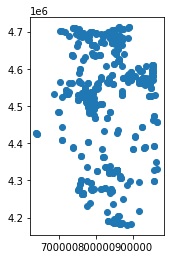

In [73]:
field_centroid.plot()

Import Homeland Infrastructure Foundation-Level Data (HIFLD) (downloaded shapefiles).

In [74]:
electricity = geopandas.GeoDataFrame.from_file('Electric_Substations/Substations.shp')
electricity.to_crs(solar_farms.crs, inplace=True)

Find nearest infrastructure lines around the centroids.

Useful link: https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas

In [75]:
def min_dist(point, gpd2):
    """
    Calculate distances from point to each point in gpd2, and sort out the nearest point.
    Input: point: a point geometry.
           gpd2: a geopandas dataframe of points.
    """
    gpd2['Dist'] = gpd2.apply(lambda row: point.distance(row.geometry),axis=1)
    geoseries = gpd2.iloc[gpd2['Dist'].argmin()]
    return geoseries

field_centroid['Nearest'] = field_centroid.apply(lambda row: min_dist(row.geometry, electricity)['ID'] , axis=1)
electricity.drop(columns=['Dist'], inplace=True)

In [92]:
field_centroid.drop_duplicates(subset=['geometry'], inplace=True)
field_centroid.reset_index(drop=True, inplace=True)

In [93]:
field_centroid

,index,geometry,Nearest
0,0,POINT (641645.255 4424984.204),153234
1,2,POINT (639264.498 4426793.428),153234
2,4,POINT (803686.698 4325749.989),122493
3,5,POINT (838808.714 4685853.605),156657
4,8,POINT (840993.678 4699506.967),121926
...,...,...,...
342,471,POINT (817772.314 4686255.997),137867
343,472,POINT (832020.861 4699664.813),121926
344,473,POINT (813079.125 4694215.789),134715
345,474,POINT (815850.044 4505932.664),155828


In [94]:
# Construct a geopandas dataframe of the nearest towers in the same order of the field centroids of the solar farms.
nearest_towers = field_centroid.copy().drop(columns=['geometry'])
nearest_towers = nearest_towers.merge(electricity, left_on='Nearest', right_on='ID', how='left')

# Calculate distances from centroid of fields to the nearest towers.
# Unit in EPSG:26915 is metre, so the distances are in meters.
field_centroid['dist_nearest_tower'] = field_centroid.distance(nearest_towers)

# Merge other attributes of the nearest tower.
nearest_towers.drop(columns=['geometry', 'Nearest', 'index'], inplace=True)
field_centroid = pd.concat([field_centroid , nearest_towers], axis=1)

# Calculate the greatest accepted distance to each tower.
field_centroid['max_dist'] = field_centroid.groupby(['ID'])['dist_nearest_tower'].transform(max)

In [144]:
# Get all fields within the max distance of each tower.
towers = field_centroid.copy().drop_duplicates(subset=['ID'])
towers.reset_index(drop=True, inplace=True)
towers['geometry'] = towers.buffer(towers.max_dist)
towers.drop(columns=['Nearest', 'dist_nearest_tower'], inplace=True)

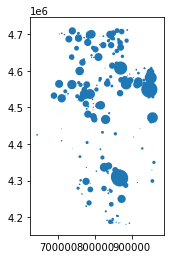

In [135]:
towers.plot()

In [157]:
def merge_point_poly_2(poly_file_path, buf):
    """
    Find polygons whose centroids are within the buffer zone.
    Input: poly_file_path: str, file path of the shapefile of polygons.
           buf: GeoDataFrame, GeoDataFrame of buffers of points.
    Output: GeoDataFrame, GeoDataFrame of polygons whose centroids are within the buffer zone.
    """
    # Construct a GeoDataFrame of polygons from the shapefile.
    poly = geopandas.GeoDataFrame.from_file(poly_file_path)
    poly_centroid = poly.copy()
    poly_centroid['geometry'] = poly.centroid
    # Transform all geometries in a point_all to crs of the polygon shapfile. 
    buf = buf.to_crs(poly.crs)
    # Spatial join of point and poly, and keep geometry of poly as the geometry of the new shapefile.
    # (It only keeps the geometry from the left GeoDataFrame. 
    pointPolys = sjoin(poly_centroid, buf, how='inner')
    # Replace the geometry with polygons. Matching by index.
    if len(pointPolys)!=0:
        pointPolys.loc[:, ['geometry']] = poly[['geometry']]
    return pointPolys

In [158]:
# Loop through all shapefiles in Illinois. Find all fields that are within the maximum distances from the electricity towers.
list_file = listdir('il')
for i in range(len(list_file)):
    file_name = list_file[i]
    if i ==0:
        output_2 = merge_point_poly_2('il/'+file_name+'/clu_public_a_'+file_name+'.shp', towers)
    else:
        m = merge_point_poly_2('il/'+file_name+'/clu_public_a_'+file_name+'.shp', towers)
        # Appended geometry columns needs to have the same CRS.
        m.to_crs(output_2.crs, inplace=True)
        output_2 = output_2.append(m)

In [180]:
output_2.dropna(subset=['ID'], inplace=True)

In [183]:
output_2.reset_index(drop=True, inplace=True)

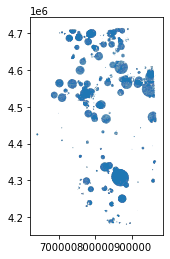

In [181]:
output_2.plot()

In [184]:
# Calculate the distance to nearest towers. (Or to the towers in our dataset?)
output_2.centroid

,CALCACRES,geometry,index_right,index,OBJECTID,ID,NAME,CITY,STATE,ZIP,...,SOURCE,SOURCEDATE,VAL_METHOD,VAL_DATE,LINES,MAX_VOLT,MIN_VOLT,MAX_INFER,MIN_INFER,max_dist
0,6.17,"POLYGON ((640750.718 4424307.671, 640757.321 4...",0.0,0.0,37921.0,153234,EAST QUINCY,QUINCY,IL,62305,...,"IMAGERY, https://www.misoenergy.org/Library/Re...",2015-04-14,IMAGERY,2017-04-27,5.0,138.0,138.0,Y,Y,2333.467904
1,3.12,"POLYGON ((640435.755 4426728.456, 640625.702 4...",0.0,0.0,37921.0,153234,EAST QUINCY,QUINCY,IL,62305,...,"IMAGERY, https://www.misoenergy.org/Library/Re...",2015-04-14,IMAGERY,2017-04-27,5.0,138.0,138.0,Y,Y,2333.467904
2,5.96,"POLYGON ((640237.784 4424286.120, 640145.195 4...",0.0,0.0,37921.0,153234,EAST QUINCY,QUINCY,IL,62305,...,"IMAGERY, https://www.misoenergy.org/Library/Re...",2015-04-14,IMAGERY,2017-04-27,5.0,138.0,138.0,Y,Y,2333.467904
3,14.19,"POLYGON ((639830.289 4425240.980, 639830.166 4...",0.0,0.0,37921.0,153234,EAST QUINCY,QUINCY,IL,62305,...,"IMAGERY, https://www.misoenergy.org/Library/Re...",2015-04-14,IMAGERY,2017-04-27,5.0,138.0,138.0,Y,Y,2333.467904
4,3.20,"POLYGON ((639828.361 4425543.057, 639827.354 4...",0.0,0.0,37921.0,153234,EAST QUINCY,QUINCY,IL,62305,...,"IMAGERY, https://www.misoenergy.org/Library/Re...",2015-04-14,IMAGERY,2017-04-27,5.0,138.0,138.0,Y,Y,2333.467904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348542,2.85,"POLYGON ((833352.351 4466098.619, 833440.776 4...",108.0,279.0,13096.0,123352,UNKNOWN123352,HEYWORTH,IL,61745,...,IMAGERY,2015-05-01,IMAGERY,2015-05-01,0.0,-999999.0,-999999.0,N,N,12605.551344
348543,18.32,"POLYGON ((832665.107 4465786.774, 832679.574 4...",108.0,279.0,13096.0,123352,UNKNOWN123352,HEYWORTH,IL,61745,...,IMAGERY,2015-05-01,IMAGERY,2015-05-01,0.0,-999999.0,-999999.0,N,N,12605.551344
348544,208.58,"POLYGON ((833254.713 4465956.729, 833231.319 4...",108.0,279.0,13096.0,123352,UNKNOWN123352,HEYWORTH,IL,61745,...,IMAGERY,2015-05-01,IMAGERY,2015-05-01,0.0,-999999.0,-999999.0,N,N,12605.551344
348545,3.74,"POLYGON ((801214.438 4544736.289, 801215.182 4...",121.0,301.0,41585.0,157085,UNKNOWN157085,SPARLAND,IL,61565,...,IMAGERY,2018-06-01,IMAGERY,2018-06-01,0.0,-999999.0,-999999.0,N,N,5928.283603


In [74]:
output.to_file("fields.shp")

<ipython-input-74-d429184222b5>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  output.to_file("fields.shp")
